In [9]:
from google.colab import drive
drive.mount('/content/drive')
caminho_drive = '/content/drive/My Drive/colab/snake/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install keras-rl2

     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 87.9MB 55kB/s 
     |████████████████████████████████| 501kB 44.8MB/s 
     |████████████████████████████████| 3.1MB 42.7MB/s 
  Created wheel for keras-rl2: filename=keras_rl2-1.0.3-cp36-none-any.whl size=52852 sha256=ea6cea3563b312620ade25a2eb1241ec49406407d6f9d93e4d531cc7a8601f5a
  Stored in directory: /root/.cache/pip/wheels/75/70/d7/65d0ca0a87c24f988435973065ef7ddf78af43a603a035aac0
Successfully built keras-rl2
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler

import gym
from gym import spaces

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from keras.callbacks.callbacks import LambdaCallback
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
def cria_modelo(n_acoes, input_shape, porc_dropout):

    rna = models.Sequential()
    rna.add(layers.Flatten(input_shape=input_shape))

    rna.add(layers.Dense(16,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(16,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(8,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(n_acoes, activation='softmax'))

    #rna.compile(optimizer='sgd', loss='mse')
    #rna.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

    return rna

In [0]:
class SnakeEnv(gym.Env):
    def __init__(self, janela_aprendizado):
        self.n_acoes = 4
        self.action_space = spaces.Discrete(self.n_acoes)
        self.observation_space = spaces.Box( low=-1 , high=1 , shape=(janela_aprendizado,) + (25, 25) )
        self.campo = None
        self.qnt_linhas = None
        self.qnt_colunas = None
        self.posicoes_cobra = []
        self.desconto_por_casa = -0.001
        self.reset()

    def observacao(self):
        obs = []
        for i in range( len(self.campo[0]) ):
            obs.append( self.campo[0][i] )
        return obs

    def step(self, acao):
        
        recompensa = None
        acabou = False
        regret = 0

        posicao_cabeca_x = self.posicoes_cobra[0][0]
        posicao_cabeca_y = self.posicoes_cobra[0][1]
        posicao_rabo_x = self.posicoes_cobra[-1][0]
        posicao_rabo_y = self.posicoes_cobra[-1][1]
        
        if acao == 0: #cima
            posicao_cabeca_y += -1
        elif acao == 1: #direita
            posicao_cabeca_x += 1
        elif acao == 2: #baixo
            posicao_cabeca_y += 1
        elif acao == 3: #esquerda
            posicao_cabeca_x += -1

        if posicao_cabeca_x >= self.qnt_linhas or posicao_cabeca_y >= self.qnt_colunas:
            recompensa = -1
        else:
            recompensa = self.campo[0][ posicao_cabeca_y ][ posicao_cabeca_x ]

        if recompensa == -1:
            acabou = True
        else:
            self.posicoes_cobra.insert(0, [ posicao_cabeca_x, posicao_cabeca_y ])
            self.campo[0][posicao_cabeca_y][posicao_cabeca_x] = -1

            if recompensa == 1:
                self.gera_maca()
            else:
                self.posicoes_cobra.pop()
                self.campo[0][posicao_rabo_y][posicao_rabo_x] = self.desconto_por_casa

        return self.observacao(), recompensa, acabou, {'regret':regret}

    def gera_maca(self):
        linha = 0
        coluna = 0
        while self.campo[0][linha][coluna] == -1:
            linha = np.random.choice( self.qnt_linhas )
            coluna = np.random.choice( self.qnt_colunas )
        self.campo[0][linha][coluna] = 1

    def reset(self):
        self.campo = np.full( self.observation_space.shape, self.desconto_por_casa )
        self.qnt_linhas = len(self.campo[0][0])
        self.qnt_colunas = len(self.campo[0])
        self.campo[0][0] = -1
        self.campo[0][-1] = -1
        for i in range(len(self.campo[0])):
            self.campo[0][i][0] = -1
            self.campo[0][i][-1] = -1
        self.posicoes_cobra.append( [int(self.qnt_linhas / 2 + 1), int(self.qnt_colunas / 2 + 1)] )
        self.posicoes_cobra.append( [self.posicoes_cobra[0][0], self.posicoes_cobra[0][1] + 1] )
        self.campo[0][ self.posicoes_cobra[0][1] ][ self.posicoes_cobra[0][0] ] = -1
        self.campo[0][ self.posicoes_cobra[-1][1] ][ self.posicoes_cobra[-1][0] ] = -1
        self.gera_maca()
        return self.observacao()

    def render(self, mode='human'):
        pass

In [14]:
np.random.seed(10)

janela_aprendizado = 1 #quantas linhas da memoria vai pegar pra treinar o modelo por vez
ambiente = SnakeEnv( janela_aprendizado ) #cria o ambiente para o jogo
n_acoes = ambiente.n_acoes #define o numero de saidas da rede
input_shape = ambiente.observation_space.shape

memoria = SequentialMemory(limit=50000, window_length=janela_aprendizado)
modelo = cria_modelo( n_acoes, input_shape, 0.2 )
metricas = ['accuracy']

n_steps_1 = 500000
n_steps_2 = 200000
n_steps_aquecimento = 100
n_steps_1_por_1000 = int(n_steps_1 / 1000)
n_steps_2_por_1000 = int(n_steps_2 / 1000)

n_max_steps_por_episodio = 1000

agora = str( datetime.now() - timedelta(hours = 3) ).replace(' ', '_') #horario de brasilia UTC-3
caminho_export = '{0}{1}_{2}k_{3}k_steps_'.format( caminho_drive, agora, n_steps_1_por_1000, n_steps_2_por_1000 )

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [15]:
eps_max = 1
eps_min = 0
politica = LinearAnnealedPolicy( inner_policy=EpsGreedyQPolicy(), attr='eps', value_max=eps_max, value_min=eps_min, nb_steps=n_steps_1, value_test=0 ) #0.2 antes do decay
agente = DQNAgent( model=modelo, policy=politica, nb_actions=n_acoes, memory=memoria, enable_double_dqn=True, test_policy=GreedyQPolicy(), nb_steps_warmup=n_steps_aquecimento )
agente.compile(optimizers.Adam(), metrics=metricas)

resultados_treino = []
intervalo_log_1 = int( n_steps_1 / 5 )
intervalo_modelo_1 = int( n_steps_1 / 5 )
callbacks_treino_1 = []
callbacks_treino_1.append( FileLogger( 'log_1.log' ) )
callbacks_treino_1.append( FileLogger( '{0}log_1.log'.format( caminho_export ) ) )
callbacks_treino_1.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_treino.append( logs ) ) )
callbacks_treino_1.append( ModelIntervalCheckpoint( '{0}dqn_1.h5f'.format( caminho_export ) , interval=intervalo_modelo_1 ) )
historia_treino = agente.fit(env=ambiente, nb_steps=n_steps_1, visualize=False, verbose=1, callbacks=callbacks_treino_1, log_interval=intervalo_log_1, nb_max_episode_steps=n_max_steps_por_episodio)
#historia_treino = agente.fit(env=ambiente, nb_steps=n_steps_1, visualize=False, verbose=0, callbacks=callbacks_treino_1)

agente.save_weights('dqn_1.h5f', overwrite=True)
agente.save_weights( '{0}dqn_1.h5f'.format( caminho_export ), overwrite=True )

Training for 500000 steps ...
Interval 1 (0 steps performed)
  9430/100000 [=>............................] - ETA: 15:15 - reward: -0.3757done, took 95.427 seconds


In [16]:
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam(), metrics=metricas)
agente.load_weights('dqn_1.h5f')

intervalo_log_2 = int( n_steps_2 / 5 )
intervalo_modelo_2 = int( n_steps_2 / 5 )
callbacks_treino_2 = []
callbacks_treino_2.append( FileLogger( 'log_2.log' ) )
callbacks_treino_2.append( FileLogger( '{0}log_2.log'.format( caminho_export ) ) )
callbacks_treino_2.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_treino.append( logs ) ) )
callbacks_treino_2.append( ModelIntervalCheckpoint( '{0}dqn_2.h5f'.format( caminho_export ) , interval=intervalo_modelo_2 ) )
historia_treino_2 = agente.fit(env=ambiente, nb_steps=n_steps_2, visualize=False, verbose=1, callbacks=callbacks_treino_2, log_interval=intervalo_log_2, nb_max_episode_steps=n_max_steps_por_episodio)
#historia_treino_2 = agente.fit(env=ambiente, nb_steps=n_steps_teste, visualize=False, verbose=0, callbacks=callbacks_treino_2)

agente.save_weights('dqn_2.h5f', overwrite=True)
agente.save_weights( '{0}dqn_2.h5f'.format( caminho_export ) , overwrite=True )

Training for 200000 steps ...
Interval 1 (0 steps performed)
 1160/40000 [..............................] - ETA: 1:44 - reward: -0.0553done, took 3.160 seconds


TypeError: ignored

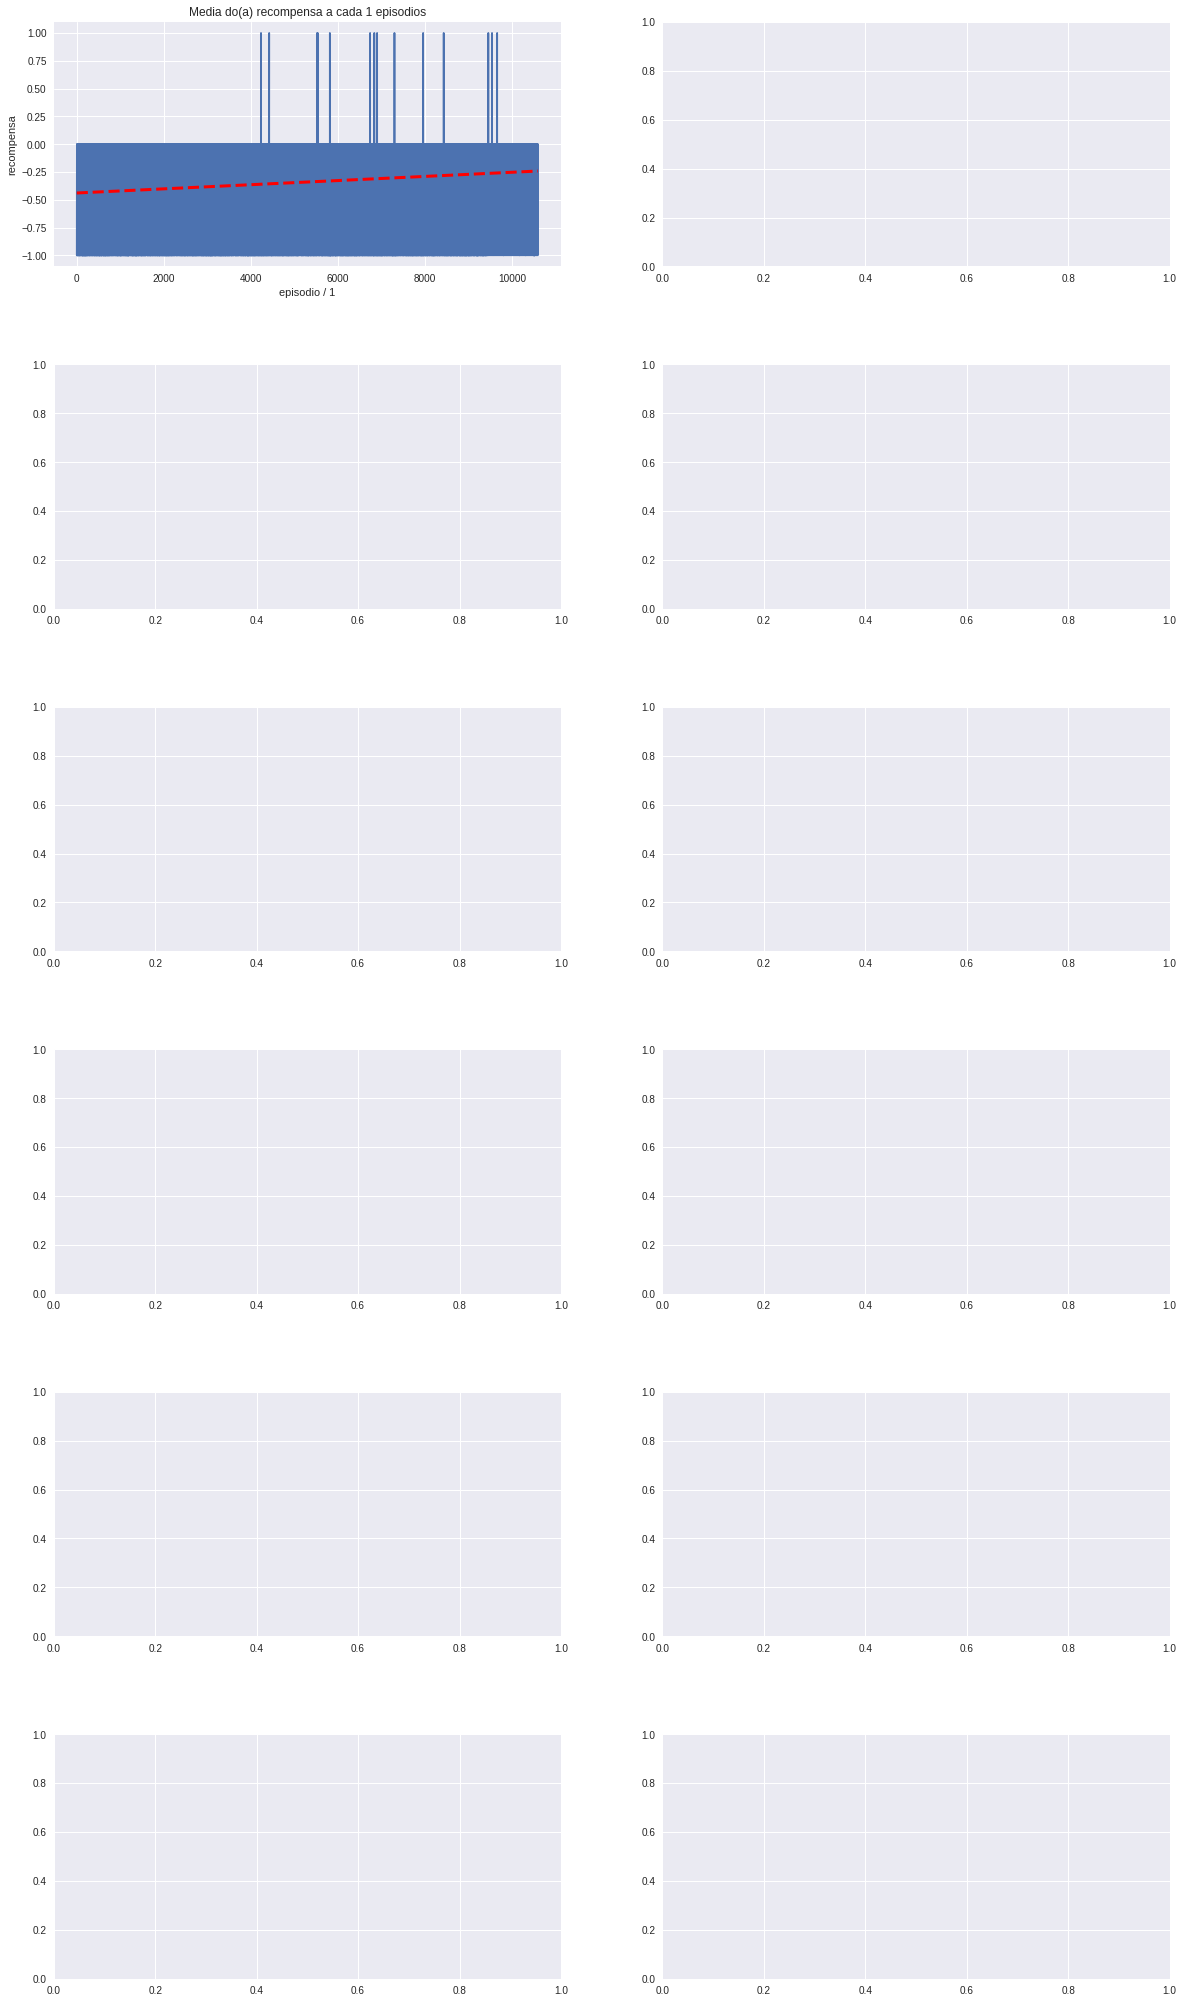

In [17]:
plt.style.use('seaborn')
#nm_metricas = ['recompensa', 'regret', 'loss', 'accuracy', 'mean_q', 'mean_eps']
nm_metricas = ['recompensa', 'regret', 'loss', 'accuracy', 'mean_q', 'mean_eps']
metrica_max = [True, True, False, True, False, False]
divisores = [1, 10] #quantidade de episodios a dividir a media
result = resultados_treino
n_resultados = len(result)
tipo = 'treino_full'
pular_n_steps = n_steps_aquecimento
fig_size_x = 20
fig_size_y = len(nm_metricas) * 6

fig, axs = plt.subplots(len(nm_metricas), len(divisores), gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=( fig_size_x , fig_size_y ))
#fig.suptitle('Medias por episodios do {}'.format(tipo))
for metrica_i in range(len(nm_metricas)):

    nm_metrica = nm_metricas[metrica_i]
    if len(divisores) == 1:
        axs[metrica_i].set(ylabel=nm_metrica)
    else:
        axs[metrica_i][0].set(ylabel=nm_metrica)
    grafico = 0

    for divisor in divisores:

        axes = None
        if len(divisores) == 1:
            axes = axs[metrica_i]
        else:
            axes = axs[metrica_i][grafico]
        grafico = 0
        axes.set(title='Media do(a) {} a cada {} episodios'.format(nm_metrica, divisor))

        hist_metricas = []
        metricas_media = []
        metricas_ref = []
        ref = result[pular_n_steps]['episode']

        # [ posicao em x do maior ponto na media , posicao y do maior ponto na media , maior ponto ]
        max_metrica_media_1 = [None, None]
        min_metrica_media_1 = [None, None]

        for i in range(0, n_resultados + 1):
            if len(hist_metricas) % divisor == 0 and len(hist_metricas) > 0:
                metricas_media.append( sum(hist_metricas[-divisor:]) / divisor )
                #pega maximos e minimos
                if max_metrica_media_1[1] == None or metricas_media[-1] >= max_metrica_media_1[1]:
                    max_metrica_media_1[0] = i / divisor
                    max_metrica_media_1[1] = metricas_media[-1]
                if min_metrica_media_1[1] == None or metricas_media[-1] <= min_metrica_media_1[1]:
                    min_metrica_media_1[0] = i / divisor
                    min_metrica_media_1[1] = metricas_media[-1]
            if (i == n_resultados or result[i]['episode'] != ref) and len(metricas_ref) > 0:
                hist_metricas.append( sum(metricas_ref) / len(metricas_ref) )
                ref += 1
                metricas_ref = []
            if i < n_resultados:
                if metrica_i == 0: #recompensa
                    metricas_ref.append( result[i]['reward'] )
                elif metrica_i == 1: #regret
                    metricas_ref.append( result[i]['info']['regret'] )
                else: #outras metricas
                    if metrica_i - 2 == len(result[i]['metrics']): #se for o epsilon
                        metricas_ref.append( 0 )
                    else:
                        if not math.isnan( result[i]['metrics'][metrica_i-2] ): #tem que ser diferente de Not a Number (NaN)
                            metricas_ref.append( result[i]['metrics'][metrica_i-2] )

        n_steps_media_treino_1 = int((n_steps_1 - pular_n_steps) / divisor)
        n_steps_media_total = len(metricas_media)
        #plota grafico
        x_plot = np.arange(n_steps_media_total)
        axes.set(xlabel='episodio / {}'.format(divisor))
        axes.plot(x_plot, metricas_media)
        #linha de tendencia antes do epsilon = 0
        z = np.polyfit(x_plot[:n_steps_media_treino_1], metricas_media[:n_steps_media_treino_1], 1)
        p = np.poly1d(z)
        axes.plot(x_plot[:n_steps_media_treino_1], p(x_plot[:n_steps_media_treino_1]), c='#ff0000', ls="--", linewidth=3, label='tendencia eps decay')
        #linha de tendencia antes do epsilon = 0
        z = np.polyfit(x_plot[n_steps_media_treino_1:], metricas_media[n_steps_media_treino_1:], 1)
        p = np.poly1d(z)
        axes.plot(x_plot[n_steps_media_treino_1:], p(x_plot[n_steps_media_treino_1:]), c='#ff0000', ls="--", linewidth=3, label='tendencia eps = 0')
        #maximo e minimo
        if metrica_max[metrica_i]:
            #linha de maximo_1
            anotacao_x_max = max_metrica_media_1[0]
            if max_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_max = n_steps_media_total * 0.9
            anotacao_y_max = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.6) + min_metrica_media_1[1]
            axes.axhline(max_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='maximo_1')
            axes.annotate( 'max_1 = {:.4f}'.format(max_metrica_media_1[1]), 
                                            xy=( max_metrica_media_1[0] , max_metrica_media_1[1] ),
                                            xytext=( anotacao_x_max , anotacao_y_max ),
                                            arrowprops=dict(facecolor='black', shrink=0.05) )
        else:
            #linha de minimo_1
            anotacao_x_min = min_metrica_media_1[0]
            if min_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_min = n_steps_media_total * 0.9
            anotacao_y_min = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.4) + min_metrica_media_1[1]
            axes.axhline(min_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='minimo_1')
            axes.annotate( 'min_1 = {:.4f}'.format(min_metrica_media_1[1]),
                                            xy=( min_metrica_media_1[0] , min_metrica_media_1[1] ),
                                            xytext=( anotacao_x_min , anotacao_y_min ),
                                            arrowprops=dict(facecolor='black', shrink=0.03) )
        #linha do epsilon = 0
        axes.axvline( x=n_steps_media_treino_1, c='#00ff00' , linewidth=1, label='epsilon = 0')
        
        grafico += 1

fig.show()
fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto
fig.savefig('{0}result_{1}.png'.format( caminho_export, tipo ), bbox_inches='tight') #salva o grafico em uma foto

In [0]:
resultados_teste = []
callbacks_teste = []
callbacks_teste.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_teste.append( logs ) ) )
agente.test(ambiente, nb_episodes=5, verbose=1, visualize=False, callbacks=callbacks_teste)

Testing for 5 episodes ...
Episode 1: reward: -1.002, steps: 3
Episode 2: reward: -1.002, steps: 3
Episode 3: reward: -1.002, steps: 3
Episode 4: reward: -1.002, steps: 3
Episode 5: reward: -1.002, steps: 3


In [0]:
!pip install pygame

     |████████████████████████████████| 11.4MB 269kB/s 


In [0]:
os.environ['SDL_VIDEODRIVER']='dummy'
pygame.display.init()
pygame.init()

tamanho_quadrados = 20
tamanho_x = ambiente.observation_space.shape[1]
tamanho_y = ambiente.observation_space.shape[2]
tela_x = tamanho_x * tamanho_quadrados
tela_y = tamanho_y * tamanho_quadrados

white = (255, 255, 255)
red = (255, 0, 0)
blue = (0,0,255)

dis = pygame.display.set_mode((tela_x,tela_y))
pygame.display.update()
pygame.display.set_caption('Snake game')
game_over = False

clock = pygame.time.Clock()

step = 0
while not game_over:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            game_over = True

    dis.fill(white)
    for i in range(tamanho_x):
        for j in range(tamanho_y):
            if resultados_teste[step]['observation'][i][j] == -1:
                pygame.draw.rect( dis , blue , [i*tamanho_quadrados,j*tamanho_quadrados,tamanho_quadrados,tamanho_quadrados] )
            elif resultados_teste[step]['observation'][i][j] == 1:
                pygame.draw.rect( dis , red , [i*tamanho_quadrados,j*tamanho_quadrados,tamanho_quadrados,tamanho_quadrados] )
    pygame.display.update()

    step += 1
    if step == len(resultados_teste):
        game_over = True

    clock.tick(1000)
 
pygame.quit()